In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from scipy.stats import kurtosis
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from datasets.HiggsBosonDataset import HiggsBosonDataset
from datasets.MappingDataset import MappingDataset
%load_ext autoreload
%autoreload 2
from utils import *

# Higgs Boson Dataset
---

In [3]:
higgs = HiggsBosonDataset()
X, y = higgs.get_train_data()

## Principal Component Analysis

Component	Explained	Cumulative
1		0.24		0.24
2		0.13		0.37
3		0.11		0.47
4		0.09		0.56
5		0.08		0.64
6		0.07		0.70
7		0.06		0.76
8		0.05		0.81
9		0.04		0.85
10		0.04		0.89
11		0.03		0.92
12		0.02		0.94
13		0.02		0.96
14		0.01		0.98
15		0.01		0.99
16		0.01		0.99
17		0.00		1.00
18		0.00		1.00


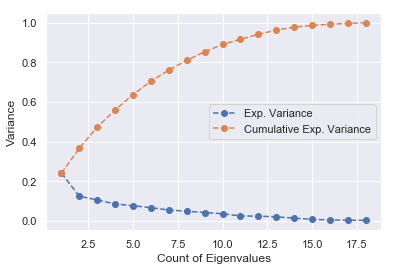

In [93]:
#Analyze Explained variance by number of features
pca = PCA()
pca.fit(X)

evars = pca.explained_variance_ratio_
cumsum_evars = np.cumsum(pca.explained_variance_ratio_)

plt.plot(np.arange(pca.n_components_)+1,evars, '--o',  label='Exp. Variance')
plt.plot(np.arange(pca.n_components_)+1,cumsum_evars, '--o', label='Cumulative Exp. Variance')
plt.xlabel('Count of Eigenvalues')
plt.ylabel('Variance')
plt.legend()

print('Component\tExplained\tCumulative')
for n, evar, cumsum_evar in zip(np.arange(pca.n_components_)+1,evars,cumsum_evars):
    print('%d\t\t%.2f\t\t%.2f'%(n,evar,cumsum_evar))

Kurtosis of Eigenvalues: 3.204


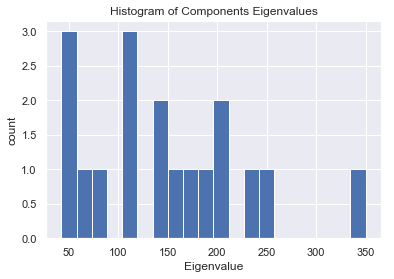

In [94]:
print('Kurtosis of Eigenvalues: %.3f' % (kurtosis(pca.singular_values_, fisher=False)))
plt.hist(pca.singular_values_, bins=20)
plt.xlabel('Eigenvalue')
plt.ylabel('count')
plt.title('Histogram of Components Eigenvalues')
plt.show()

Explained Var: 0.10	 MSE: 98395.548
Explained Var: 0.20	 MSE: 98395.548
Explained Var: 0.30	 MSE: 90666.454
Explained Var: 0.40	 MSE: 83116.693
Explained Var: 0.50	 MSE: 75208.948
Explained Var: 0.60	 MSE: 68947.921
Explained Var: 0.70	 MSE: 60968.418
Explained Var: 0.80	 MSE: 48445.710
Explained Var: 0.90	 MSE: 30775.484
Explained Var: 0.99	 MSE: 8602.696


Text(0.5, 1.0, 'Reprojection Error by Variance of Projection')

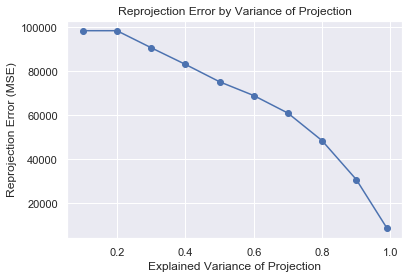

In [101]:
variances = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])
reproj_error = list()
for var in variances:
    pca = PCA(n_components = var)
    mse = calculate_reprojection_error(X, pca)
    reproj_error.append(mse)
    print('Explained Var: %.2f\t MSE: %.3f'%(var, mse))
    
plt.plot(variances,reproj_error, '-o')
plt.xlabel('Explained Variance of Projection')
plt.ylabel('Reprojection Error (MSE)')
plt.title('Reprojection Error by Variance of Projection')


## Iterative Component Analysis

In [123]:
ica = FastICA()
x_trans = ica.fit_transform(X)

Avg Kurtosis: 3.33


Text(0.5, 1.0, 'Kurtosis of Projected Axis: ICA')

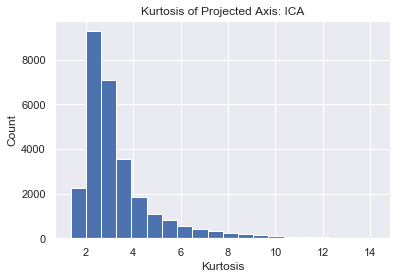

In [124]:
kurt = kurtosis(x_trans, axis=1, fisher=False)
print('Avg Kurtosis: %.2f' % (np.mean(kurt)))
plt.hist(kurt,bins=20)
plt.xlabel('Kurtosis')
plt.ylabel('Count')
plt.title('Kurtosis of Projected Axis: ICA')

In [136]:
num_comps = np.arange(1,X.shape[1]+1,1)
kurts = list()
for n in num_comps:
    ica = FastICA(n)
    x_trans = ica.fit_transform(X)
    kurts.append(np.mean(kurtosis(x_trans, axis=1, fisher=False)))
    

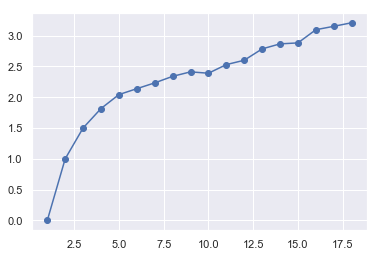

In [138]:
plt.plot(num_comps, kurts,'-o')

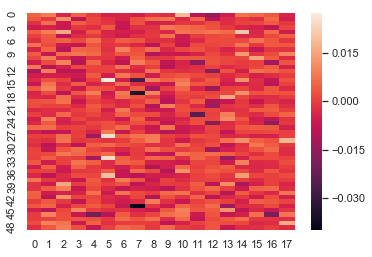

In [141]:
sns.heatmap(x_trans[:50,:])

## Randomized Projection

In [144]:
ran = GaussianRandomProjection()

In [165]:
iters = 100
rows = list()
for n in range(1,19):
    reproj_error = list()
    for _ in range(iters):
        ran = GaussianRandomProjection(n_components=n)
        x_trans = ran.fit_transform(X)
        mse = calculate_reprojection_error(X, ran,random=True)
        reproj_error.append(mse)
    rows.append([n, np.mean(reproj_error, np.std(reproj_error)])

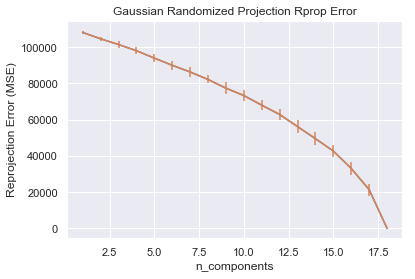

N	Mean		Std
1	108032.01	999.76
2	104562.74	1224.66
3	101386.53	1706.52
4	98003.89	1835.31
5	93896.24	2089.53
6	89940.90	2313.06
7	86274.26	2561.27
8	82121.89	2213.54
9	77326.16	3152.67
10	73256.12	2861.59
11	67951.34	2906.44
12	62826.77	3169.48
13	56126.02	3465.38
14	49469.54	3554.12
15	42620.33	3222.28
16	33042.16	3349.40
17	21330.88	3202.22
18	0.00	0.00


In [182]:
df = pd.DataFrame(rows,columns=['n_components','mean_mse','std_mse'])
ax = sns.lineplot(x='n_components',y='mean_mse', ci='std_mse', data=df)
ax.errorbar(df.index+1, df['mean_mse'], df['std_mse'],fmt='-')
plt.ylabel('Reprojection Error (MSE)')
plt.title('Gaussian Randomized Projection Rprop Error')
plt.show()

print('N\tMean\t\tStd')
for row in rows:
    
    print('%d\t%.2f\t%.2f' % (row[0],row[1],row[2]))

## TreeBased Feature Selection Model

In [11]:
clf = ExtraTreesClassifier(n_estimators=100)
clf = clf.fit(X,y)

In [12]:
selector = SelectFromModel(clf, prefit=True)
X_trans = selector.transform(X)

(28125, 7)


Text(0.5, 1.0, 'Feature Importance on Higgs Dataset')

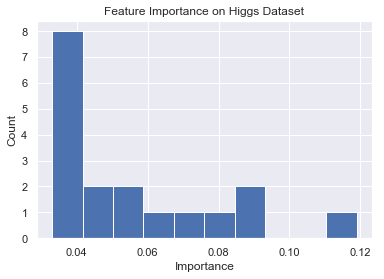

In [200]:
plt.hist(clf.feature_importances_)
plt.xlabel('Importance')
plt.ylabel('Count')
plt.title('Feature Importance on Higgs Dataset')

Text(0, 0.5, 'Importance')

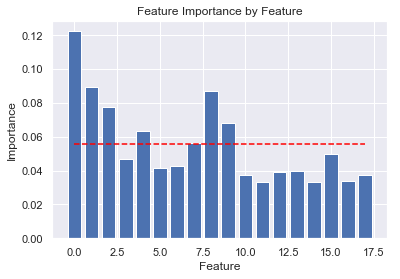

In [23]:
plt.bar(np.arange(len(clf.feature_importances_)),clf.feature_importances_)
plt.plot(np.arange(len(clf.feature_importances_)),[np.mean(clf.feature_importances_)]*len(clf.feature_importances_),'--',label='mean',color='red')
plt.title('Feature Importance by Feature')
plt.xlabel('Feature')
plt.ylabel('Importance')

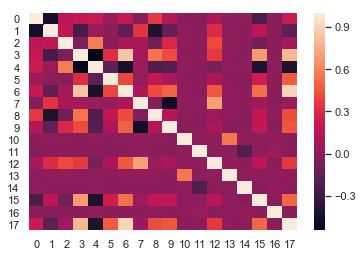

In [9]:
perm = np.random.permutation(X.shape[0])
cov_mat = np.cov(X,rowvar=False)
sns.heatmap(cov_mat)
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title()

# Mapping Dataset
---

In [36]:
mapping = MappingDataset()
X, y = mapping.get_train_data()

In [37]:
X.shape

(10545, 28)

## Principal Component Analysis

Component	Explained	Cumulative
1		0.26		0.26
2		0.12		0.39
3		0.07		0.45
4		0.06		0.51
5		0.04		0.55
6		0.04		0.59
7		0.03		0.62
8		0.03		0.65
9		0.03		0.68
10		0.03		0.71
11		0.02		0.73
12		0.02		0.76
13		0.02		0.78
14		0.02		0.80
15		0.02		0.82
16		0.02		0.84
17		0.02		0.86
18		0.02		0.87
19		0.02		0.89
20		0.02		0.91
21		0.02		0.92
22		0.01		0.94
23		0.01		0.95
24		0.01		0.96
25		0.01		0.98
26		0.01		0.99
27		0.01		1.00
28		0.00		1.00


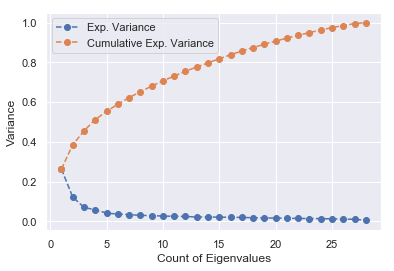

In [25]:
#Analyze Explained variance by number of features
pca = PCA()
pca.fit(X)

evars = pca.explained_variance_ratio_
cumsum_evars = np.cumsum(pca.explained_variance_ratio_)

plt.plot(np.arange(pca.n_components_)+1,evars, '--o',  label='Exp. Variance')
plt.plot(np.arange(pca.n_components_)+1,cumsum_evars, '--o', label='Cumulative Exp. Variance')
plt.xlabel('Count of Eigenvalues')
plt.ylabel('Variance')
plt.legend()

print('Component\tExplained\tCumulative')
for n, evar, cumsum_evar in zip(np.arange(pca.n_components_)+1,evars,cumsum_evars):
    print('%d\t\t%.2f\t\t%.2f'%(n,evar,cumsum_evar))

Kurtosis of Eigenvalues: 9.935


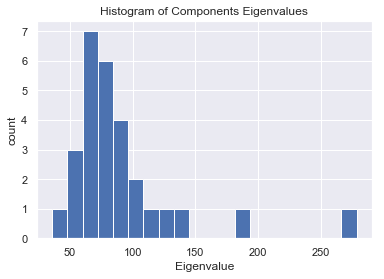

In [26]:
print('Kurtosis of Eigenvalues: %.3f' % (kurtosis(pca.singular_values_, fisher=False)))
plt.hist(pca.singular_values_, bins=20)
plt.xlabel('Eigenvalue')
plt.ylabel('count')
plt.title('Histogram of Components Eigenvalues')
plt.show()

Explained Var: 0.10	 MSE: 47232.548
Explained Var: 0.20	 MSE: 47232.548
Explained Var: 0.30	 MSE: 42578.785
Explained Var: 0.40	 MSE: 40020.127
Explained Var: 0.50	 MSE: 37870.321
Explained Var: 0.60	 MSE: 33164.005
Explained Var: 0.70	 MSE: 29194.904
Explained Var: 0.80	 MSE: 22878.741
Explained Var: 0.90	 MSE: 16145.050
Explained Var: 0.99	 MSE: 2713.962


Text(0.5, 1.0, 'Reprojection Error by Variance of Projection')

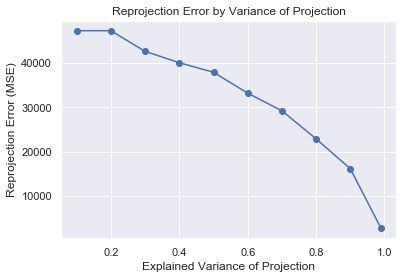

In [27]:
variances = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])
reproj_error = list()
for var in variances:
    pca = PCA(n_components = var)
    mse = calculate_reprojection_error(X, pca)
    reproj_error.append(mse)
    print('Explained Var: %.2f\t MSE: %.3f'%(var, mse))
    
plt.plot(variances,reproj_error, '-o')
plt.xlabel('Explained Variance of Projection')
plt.ylabel('Reprojection Error (MSE)')
plt.title('Reprojection Error by Variance of Projection')


## Iterative Component Analysis

In [28]:
ica = FastICA()
x_trans = ica.fit_transform(X)

/Users/albutko/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Avg Kurtosis: 3.53


Text(0.5, 1.0, 'Kurtosis of Projected Axis: ICA')

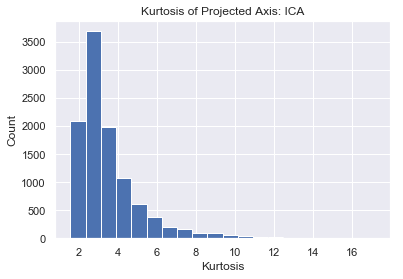

In [29]:
kurt = kurtosis(x_trans, axis=1, fisher=False)
print('Avg Kurtosis: %.2f' % (np.mean(kurt)))
plt.hist(kurt,bins=20)
plt.xlabel('Kurtosis')
plt.ylabel('Count')
plt.title('Kurtosis of Projected Axis: ICA')

In [45]:
num_comps = np.arange(1,X.shape[1]+1,1)
kurts = list()
for n in num_comps:
    print(n)
    ica = FastICA(n,tol=0.2)
    x_trans = ica.fit_transform(X)
    kurts.append(np.mean(kurtosis(x_trans, axis=1, fisher=False)))
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


/Users/albutko/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


28


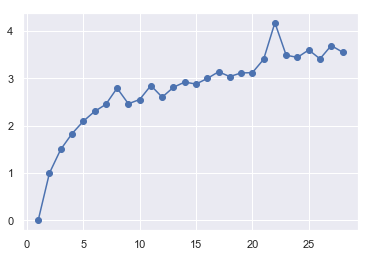

In [46]:
plt.plot(num_comps, kurts,'-o')

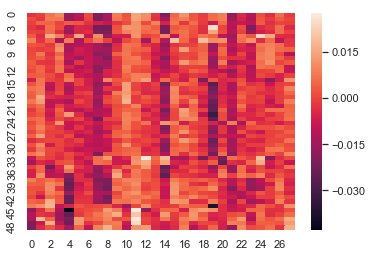

In [47]:
sns.heatmap(x_trans[:50,:])

## Randomized Projection

In [48]:
ran = GaussianRandomProjection()

In [52]:
iters = 100
rows = list()
for n in range(1,X.shape[1]+1):
    reproj_error = list()
    for _ in range(iters):
        ran = GaussianRandomProjection(n_components=n)
        x_trans = ran.fit_transform(X)
        mse = calculate_reprojection_error(X, ran,random=True)
        reproj_error.append(mse)
    rows.append([n, np.mean(reproj_error), np.std(reproj_error)])

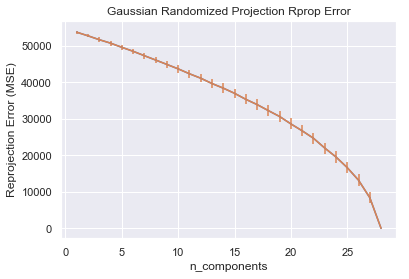

N	Mean		Std
1	53793.28	411.94
2	52802.49	417.99
3	51737.95	622.08
4	50790.52	682.13
5	49649.23	735.08
6	48564.35	675.20
7	47348.47	784.12
8	46164.43	931.43
9	44954.11	1024.86
10	43739.52	1048.45
11	42393.91	1035.59
12	41180.29	1122.91
13	39716.12	1294.25
14	38453.77	1443.84
15	37036.50	1251.32
16	35385.55	1367.56
17	33951.58	1446.75
18	32292.55	1449.43
19	30673.92	1381.07
20	28642.27	1506.58
21	26754.36	1504.78
22	24714.53	1562.82
23	22033.72	1505.44
24	19577.27	1624.09
25	16650.97	1591.04
26	13212.56	1668.76
27	8407.70	1432.23
28	0.00	0.00


In [53]:
df = pd.DataFrame(rows,columns=['n_components','mean_mse','std_mse'])
ax = sns.lineplot(x='n_components',y='mean_mse', ci='std_mse', data=df)
ax.errorbar(df.index+1, df['mean_mse'], df['std_mse'],fmt='-')
plt.ylabel('Reprojection Error (MSE)')
plt.title('Gaussian Randomized Projection Rprop Error')
plt.show()

print('N\tMean\t\tStd')
for row in rows:
    
    print('%d\t%.2f\t%.2f' % (row[0],row[1],row[2]))

## TreeBased Feature Selection Model

In [54]:
clf = ExtraTreesClassifier(n_estimators=100)
clf = clf.fit(X,y)

In [55]:
selector = SelectFromModel(clf, prefit=True)
X_trans = selector.transform(X)
print(X_trans.shape)

(10545, 8)


Text(0.5, 1.0, 'Feature Importance on Higgs Dataset')

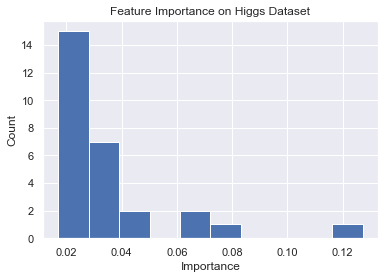

In [56]:
plt.hist(clf.feature_importances_)
plt.xlabel('Importance')
plt.ylabel('Count')
plt.title('Feature Importance on Higgs Dataset')

Text(0, 0.5, 'Importance')

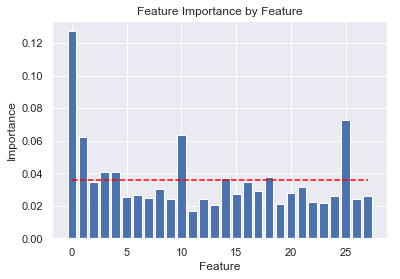

In [57]:
plt.bar(np.arange(len(clf.feature_importances_)),clf.feature_importances_)
plt.plot(np.arange(len(clf.feature_importances_)),[np.mean(clf.feature_importances_)]*len(clf.feature_importances_),'--',label='mean',color='red')
plt.title('Feature Importance by Feature')
plt.xlabel('Feature')
plt.ylabel('Importance')

TypeError: title() missing 1 required positional argument: 'label'

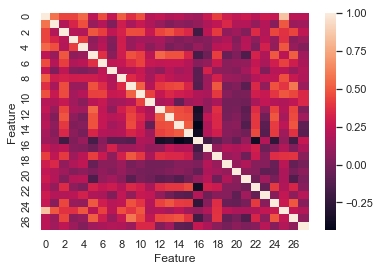

In [58]:
perm = np.random.permutation(X.shape[0])
cov_mat = np.cov(X,rowvar=False)
sns.heatmap(cov_mat)
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title()